In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay, log_loss, roc_curve, auc
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import label_binarize


In [125]:
# data type
processed_data = pd.read_csv("../data/final_df.csv")
mca_data_75 = pd.read_csv("../data/mca_components.csv")
smote_data = pd.read_csv("../data/df_smote_with_target.csv").iloc[:, :-1]
mca_smote_data_75 = pd.read_csv("../data/mca_components_smote_75.csv")
mca_smote_data_95 = pd.read_csv("../data/mca_components_smote_95.csv")


# Single Run

In [126]:
X = mca_smote_data_75
SMOTE = True

In [127]:
if SMOTE:
				ground_truth = pd.read_csv("../data/df_smote_with_target.csv").iloc[:,-1]

else:
				ground_truth = pd.read_csv("../data/Rawdata.csv", encoding='cp1252')["POLICY3"]


truth1 = """Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe."""
truth2 = """The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice."""
truth3 = """This is all an overreaction. The disease is not that serious. We should relax social distancing measure right away."""
					
labels = [truth1, truth2, truth3]
labels = [-1,0,1]
					
y = []
for truth in ground_truth:
				if truth == truth1:
								y.append(-1)
				elif truth == truth2:
								y.append(0)
				else:
								y.append(1)
				


In [128]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, train_size = 0.6)


In [129]:
LR = 0.0001
MAX_ITER = 1000
TOL = 1e-10
# ALPHA = 0.00001

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_stochastic_gradient.py:744: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


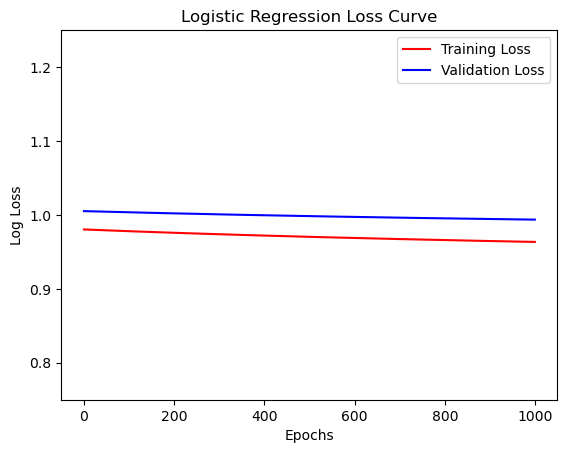

In [130]:
# model = LogisticRegression()
model = SGDClassifier(
	loss='log_loss', 
	max_iter=MAX_ITER, 
	learning_rate="constant", 
	eta0 = LR, 
	tol=TOL)

model.fit(X_train, y_train)
# y_pred = model.predict(X_test)
model.partial_fit(X_train, y_train, classes=labels)

loss_list = []
val_loss_list = []
accuracy_list = []


for _ in range(MAX_ITER):
				model.partial_fit(X_train, y_train, classes=labels)
				y_pred_proba = model.predict_proba(X_train)
				loss = log_loss(y_train, y_pred_proba, labels=labels)
				loss_list.append(loss)

				y_pred = model.predict(X_test)
				accuracy = accuracy_score(y_test, y_pred)
				accuracy_list.append(accuracy)

				y_pred_proba_val = model.predict_proba(X_test)
				val_loss = log_loss(y_test, y_pred_proba_val, labels=labels)
				val_loss_list.append(val_loss)



plt.plot(range(MAX_ITER), loss_list, label='Training Loss', color='red')
plt.plot(range(MAX_ITER), val_loss_list, label='Validation Loss', color='blue')
# plt.plot(range(MAX_ITER), accuracy_list, label='Accuracy', color='green')
plt.title("Logistic Regression Loss Curve")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Log Loss")
plt.ylim(0.75, 1.25)
plt.show()


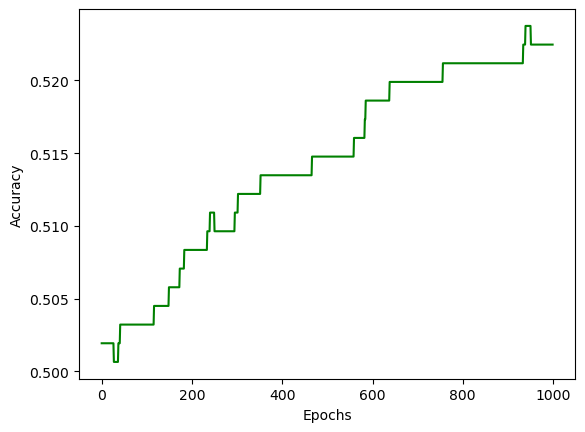

In [131]:
plt.plot(range(MAX_ITER), accuracy_list, label='Accuracy', color='green')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
# plt.ylim(0.4, 0.6)
plt.show()

In [132]:
# metrics
# accuracy = accuracy_score(y_test, y_pred)
# print(f"Accuracy: {accuracy}")

# not_random = 0
# pred_prob = model.predict_proba(X_test)
# for item in pred_prob:
#    if any(num > 0.5 for num in item):
# 				not_random+=1
# print(f"Percentage of predictions >50%: {not_random/len(X_test)}")

conf_matrix = confusion_matrix(y_test, y_pred)
print(f"Confusion_matrix:\n{conf_matrix}")



Confusion_matrix:
[[ 96 104  69]
 [ 48 176  36]
 [ 42  73 135]]


# All Datasets

In [133]:
# define hyperparameters for all models
LR_all = 0.0001
MAX_ITER_all = 1000
TOL_all = 1e-10
ALPHA_all = 0.00001

In [134]:
def evaluate_model(model, X_test, y_test, dataset_name=""):

    # do predictions
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)

    # map labels
    label_map = {
        "Coronavirus is a serious illness and we should continue social distancing measures until we can safely relax them, but try to re-open as much as possible as soon as it is reasonable safe.": "Somewhat Worried",
        "The disease is a large threat to the health of the nation that will force unconscionable choices if we do not all act together to socially distance for as long as needed even if that means great personal sacrifice.": "Very Worried",
        "This is all an overreaction. The disease is not that serious.  We should relax social distancing measure right away.": "Not Worried"
    }
    y_test_mapped = [label_map[label] for label in y_test]
    y_pred_mapped = [label_map[label] for label in y_pred]

    # compute accuracy and number of confident predictions.
    accuracy = accuracy_score(y_test_mapped, y_pred_mapped)
    print(f"\n=== Logistic Regression Metrics for {dataset_name} ===")
    print(f"Accuracy: {accuracy:.2f}")
    not_random = sum(any(prob > 0.5 for prob in item) for item in y_proba)
    print(f"Predictions >50% confidence: {not_random / len(X_test):.2f}")

    # confusion matrix
    ConfusionMatrixDisplay.from_predictions(y_test_mapped, y_pred_mapped, normalize="true")

    # classification report
    print("\nClassification Report:")
    print(classification_report(y_test_mapped, y_pred_mapped, zero_division=0))

    # binarize for AUC-ROC
    classes = sorted(set(y_test))
    custom_labels = [label_map[label] for label in classes]
    y_test_bin = label_binarize(y_test, classes=classes)
    n_classes = len(classes)

    # computations for AUC-ROC
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        print(f"{custom_labels[i]} AUC: {roc_auc[i]:.2f}")
    macro_auc = sum(roc_auc[i] for i in range(n_classes)) / n_classes
    print(f"Macro-average AUC: {macro_auc:.2f}")
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print(f"Micro-average AUC: {roc_auc['micro']:.2f}")

    # plot in target order
    target_order = ["Not Worried", "Somewhat Worried", "Very Worried"]
    colors = ["#A8D5BA", "#FFE299", "#F28C8C"]
    plt.figure(figsize=(8, 6))
    for i, label in enumerate(target_order):
        idx = custom_labels.index(label)
        plt.plot(fpr[idx], tpr[idx], color=colors[i],
                 label=f"{label} (AUC = {roc_auc[idx]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--', label="Chance")
    plt.xlabel("False Positive Rate", fontweight='bold', labelpad=10)
    plt.ylabel("True Positive Rate", fontweight='bold', labelpad=10)
    plt.title(f"Multi-class ROC Curve ({dataset_name})", pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.tight_layout()
    plt.show()

In [135]:
def train_and_evaluate(X_train, y_train, X_test, y_test, dataset_name=""):

				# initialize model
				model = SGDClassifier(
					loss='log_loss', 
					max_iter=MAX_ITER_all, 
					learning_rate="constant", 
					eta0 = LR_all, 
					tol=TOL_all)

				# initialize lists for tracking
				loss_list = []
				val_loss_list = []
				accuracy_list = []

				# partial fit
				model.partial_fit(X_train, y_train, classes=sorted(set(y_train)))

				# epoch loop
				for _ in range(MAX_ITER):
								model.partial_fit(X_train, y_train)

								y_pred_proba = model.predict_proba(X_train)
								loss = log_loss(y_train, y_pred_proba)
								loss_list.append(loss)

								y_pred = model.predict(X_test)
								accuracy = accuracy_score(y_test, y_pred)
								accuracy_list.append(accuracy)

								y_pred_proba_val = model.predict_proba(X_test)
								val_loss = log_loss(y_test, y_pred_proba_val)
								val_loss_list.append(val_loss)


				# loss curves
				plt.plot(range(MAX_ITER), loss_list, label='Training Loss', color='red')
				plt.plot(range(MAX_ITER), val_loss_list, label='Validation Loss', color='blue')
				plt.plot(range(MAX_ITER), accuracy_list, label='Accuracy', color='green')
				plt.title(f"Logistic Regression Loss Curve for {dataset_name}", pad=20)
				plt.legend()
				plt.xlabel("Epochs", fontweight='bold', labelpad=10)
				plt.ylabel("Log Loss", fontweight='bold', labelpad=10)
				# plt.ylim(0.75, 1.25)
				plt.show()

				# accuracy
				# plt.plot(range(MAX_ITER), accuracy_list, label='Accuracy', color='green')
				# plt.title(f"Logistic Regression Accuracy for {dataset_name}", pad=20)
				# plt.xlabel("Epochs", fontweight='bold', labelpad=10)
				# plt.ylabel("Accuracy", fontweight='bold', labelpad=10)
				# plt.ylim(0, 1)
				# plt.show()

				# evaluation
				evaluate_model(model, X_test, y_test, dataset_name)

In [136]:
# prepare data according to dataset format
def prepare_and_split(X, is_smote):
    if is_smote:
                    ground_truth = pd.read_csv("../data/df_smote_with_target.csv").iloc[:,-1]

    else:
                    ground_truth = pd.read_csv("../data/Rawdata.csv", encoding='cp1252')["POLICY3"]
    y = ground_truth
    return train_test_split(X, y, test_size = 0.4, train_size = 0.6)

In [137]:
X_train_raw, X_test_raw, y_train_raw, y_test_raw = prepare_and_split(processed_data, is_smote=False)
X_train_mca, X_test_mca, y_train_mca, y_test_mca = prepare_and_split(mca_data_75, is_smote=False)
X_train_smote, X_test_smote, y_train_smote, y_test_smote = prepare_and_split(smote_data, is_smote=True)
X_train_mca_smote_75, X_test_mca_smote_75, y_train_mca_smote_75, y_test_mca_smote_75 = prepare_and_split(mca_smote_data_75, is_smote=True)
X_train_mca_smote_95, X_test_mca_smote_95, y_train_mca_smote_95, y_test_mca_smote_95 = prepare_and_split(mca_smote_data_95, is_smote=True)

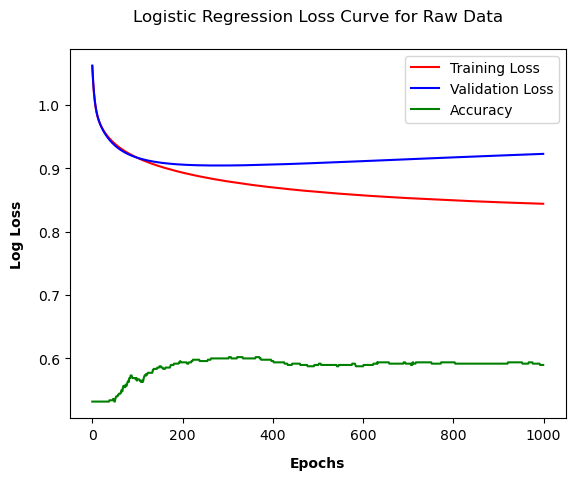


=== Logistic Regression Metrics for Raw Data ===
Accuracy: 0.59
Predictions >50% confidence: 0.72

Classification Report:
                  precision    recall  f1-score   support

     Not Worried       0.65      0.34      0.44       104
Somewhat Worried       0.60      0.83      0.70       258
    Very Worried       0.50      0.30      0.38       123

        accuracy                           0.59       485
       macro avg       0.58      0.49      0.50       485
    weighted avg       0.58      0.59      0.56       485

Somewhat Worried AUC: 0.65
Very Worried AUC: 0.68
Not Worried AUC: 0.76
Macro-average AUC: 0.69
Micro-average AUC: 0.76


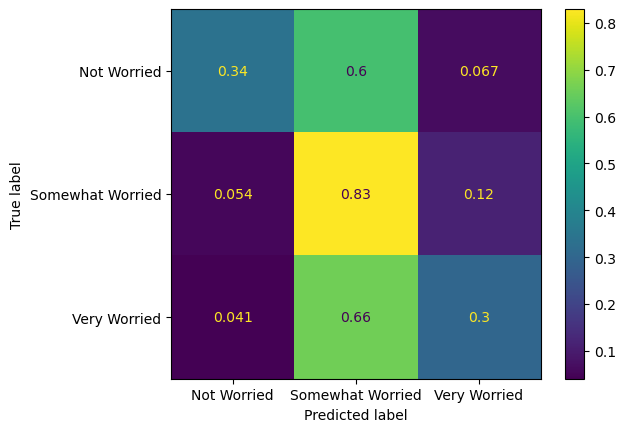

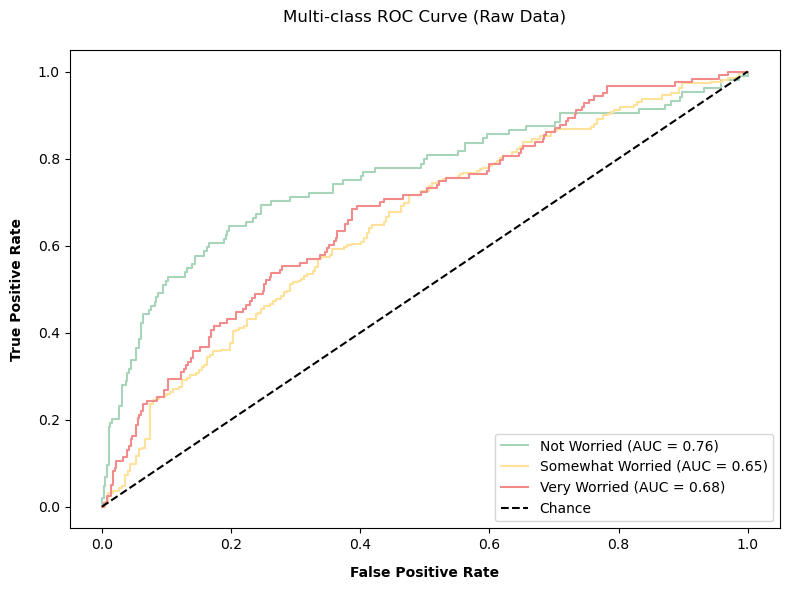

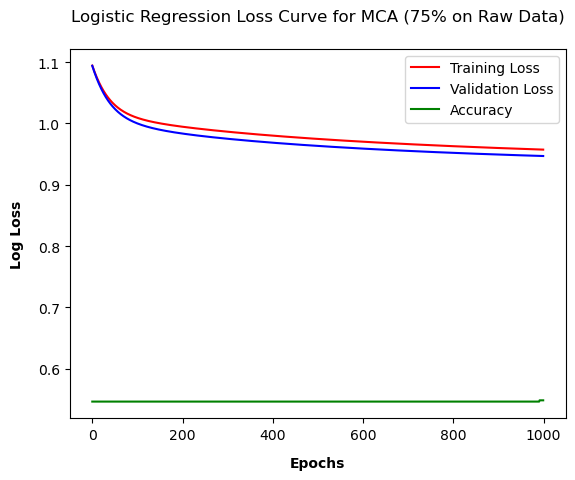


=== Logistic Regression Metrics for MCA (75% on Raw Data) ===
Accuracy: 0.55
Predictions >50% confidence: 0.73

Classification Report:
                  precision    recall  f1-score   support

     Not Worried       0.00      0.00      0.00       100
Somewhat Worried       0.55      1.00      0.71       265
    Very Worried       1.00      0.01      0.02       120

        accuracy                           0.55       485
       macro avg       0.52      0.34      0.24       485
    weighted avg       0.55      0.55      0.39       485

Somewhat Worried AUC: 0.62
Very Worried AUC: 0.67
Not Worried AUC: 0.70
Macro-average AUC: 0.67
Micro-average AUC: 0.74


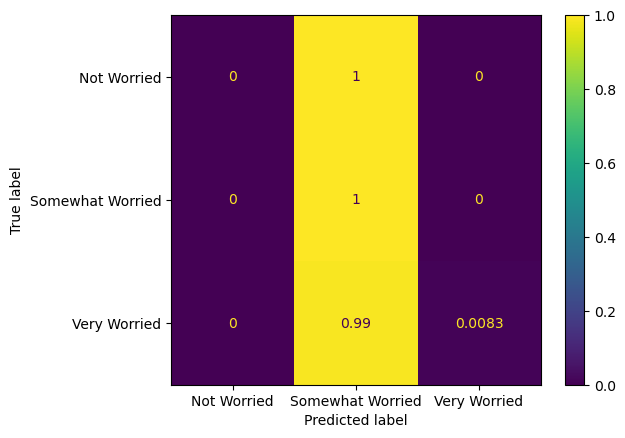

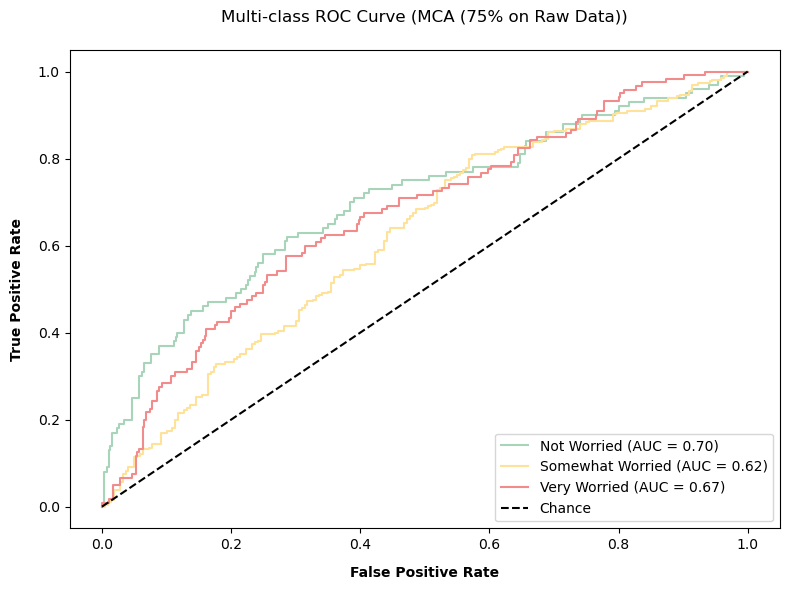

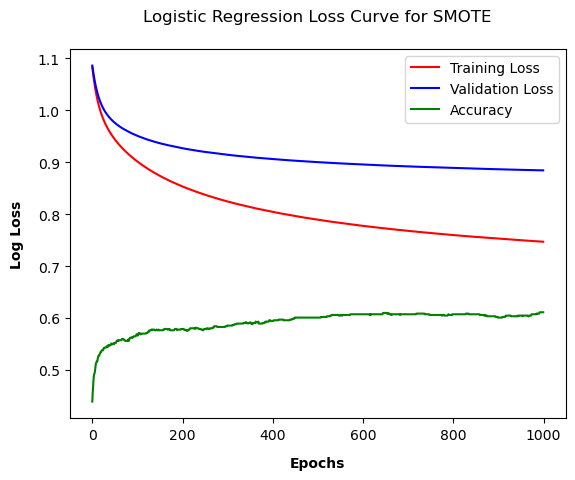


=== Logistic Regression Metrics for SMOTE ===
Accuracy: 0.61
Predictions >50% confidence: 0.74

Classification Report:
                  precision    recall  f1-score   support

     Not Worried       0.67      0.55      0.60       260
Somewhat Worried       0.56      0.67      0.61       239
    Very Worried       0.62      0.62      0.62       280

        accuracy                           0.61       779
       macro avg       0.62      0.61      0.61       779
    weighted avg       0.62      0.61      0.61       779

Somewhat Worried AUC: 0.80
Very Worried AUC: 0.77
Not Worried AUC: 0.79
Macro-average AUC: 0.79
Micro-average AUC: 0.78


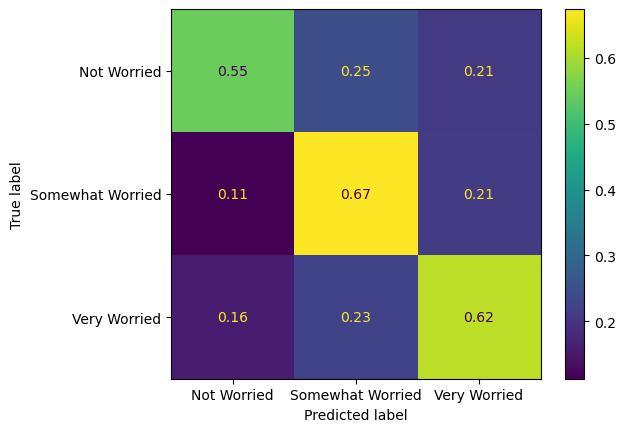

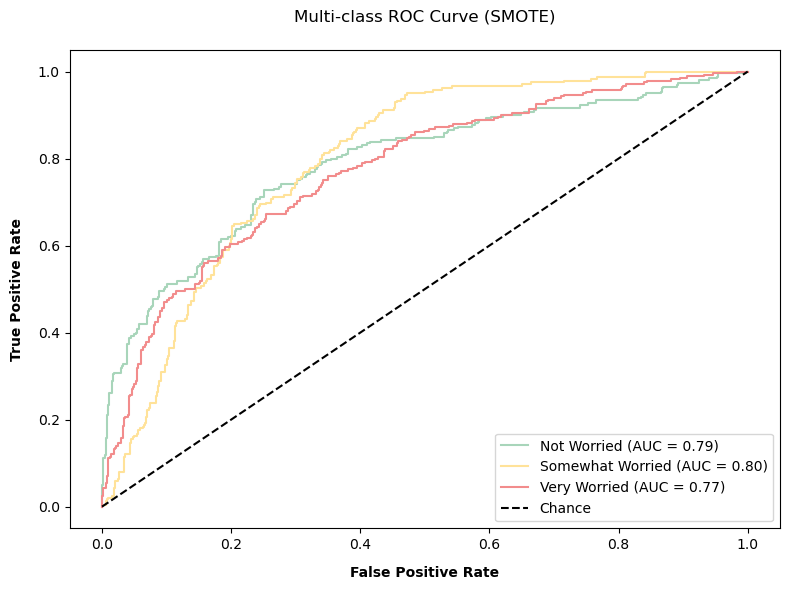

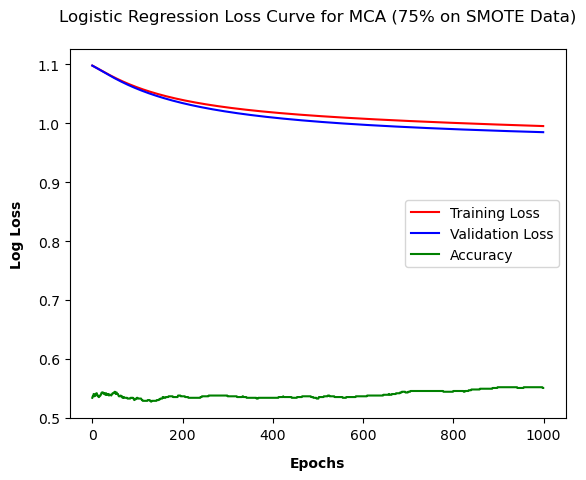


=== Logistic Regression Metrics for MCA (75% on SMOTE Data) ===
Accuracy: 0.55
Predictions >50% confidence: 0.25

Classification Report:
                  precision    recall  f1-score   support

     Not Worried       0.60      0.52      0.55       269
Somewhat Worried       0.50      0.42      0.46       250
    Very Worried       0.55      0.72      0.62       260

        accuracy                           0.55       779
       macro avg       0.55      0.55      0.54       779
    weighted avg       0.55      0.55      0.54       779

Somewhat Worried AUC: 0.69
Very Worried AUC: 0.76
Not Worried AUC: 0.70
Macro-average AUC: 0.72
Micro-average AUC: 0.72


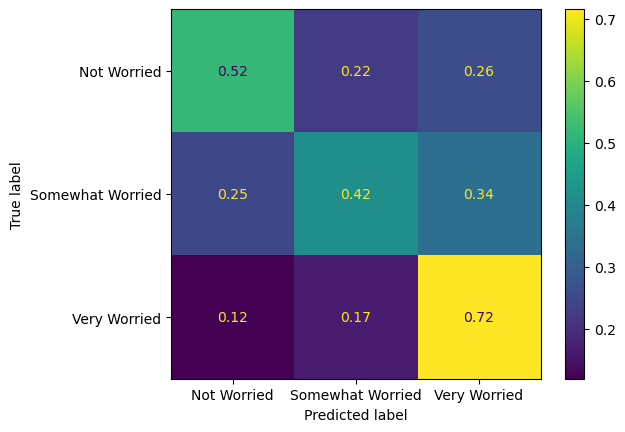

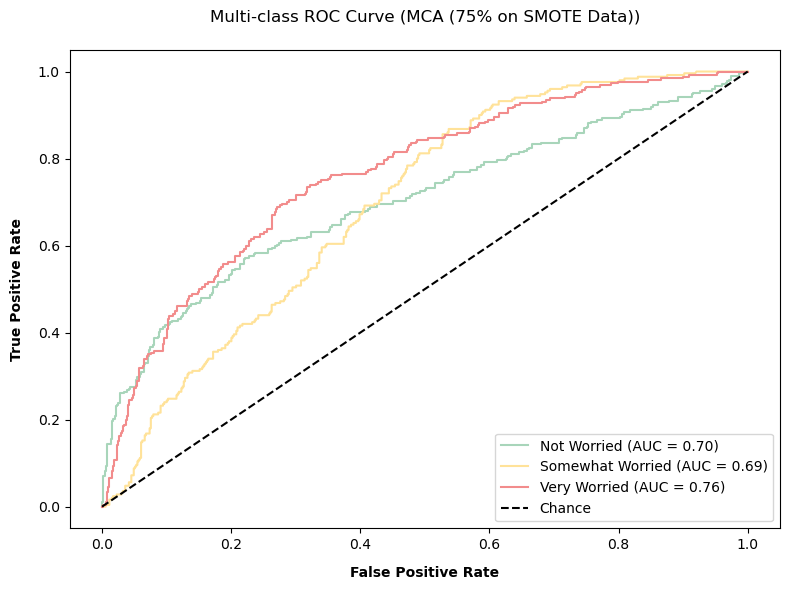

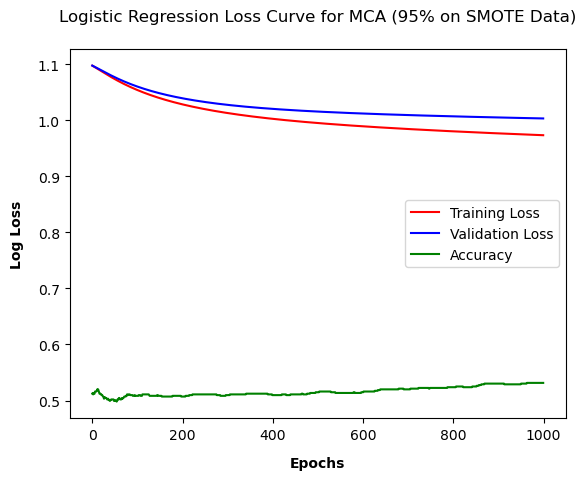


=== Logistic Regression Metrics for MCA (95% on SMOTE Data) ===
Accuracy: 0.53
Predictions >50% confidence: 0.35

Classification Report:
                  precision    recall  f1-score   support

     Not Worried       0.58      0.49      0.53       264
Somewhat Worried       0.51      0.42      0.46       250
    Very Worried       0.51      0.68      0.59       265

        accuracy                           0.53       779
       macro avg       0.53      0.53      0.52       779
    weighted avg       0.53      0.53      0.53       779

Somewhat Worried AUC: 0.69
Very Worried AUC: 0.73
Not Worried AUC: 0.67
Macro-average AUC: 0.69
Micro-average AUC: 0.69


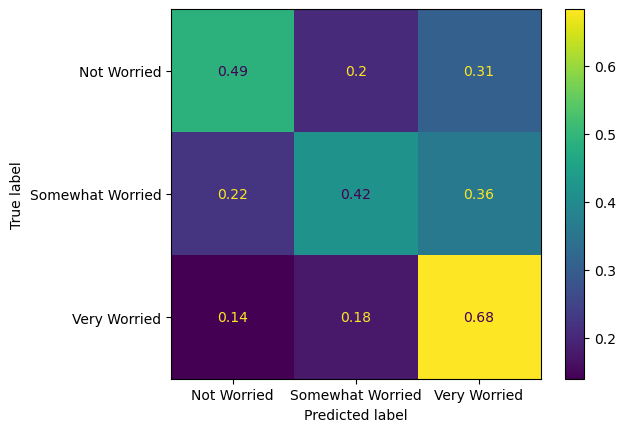

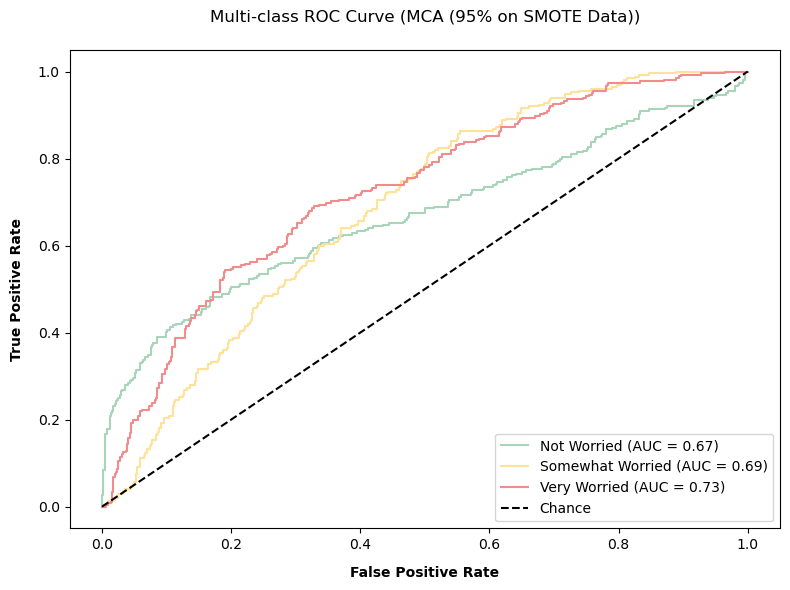

In [138]:
train_and_evaluate(X_train_raw, y_train_raw, X_test_raw, y_test_raw, "Raw Data")
train_and_evaluate(X_train_mca, y_train_mca, X_test_mca, y_test_mca, "MCA (75% on Raw Data)")
train_and_evaluate(X_train_smote, y_train_smote, X_test_smote, y_test_smote, "SMOTE")
train_and_evaluate(X_train_mca_smote_75, y_train_mca_smote_75, X_test_mca_smote_75, y_test_mca_smote_75, "MCA (75% on SMOTE Data)")
train_and_evaluate(X_train_mca_smote_95, y_train_mca_smote_95, X_test_mca_smote_95, y_test_mca_smote_95, "MCA (95% on SMOTE Data)")